This first part just copies over work done during the course into the jupyter notebook.

## Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Project starts here:

First we're going to look at the survey of parents, teachers, and students and see how those correlate to SAT scores.

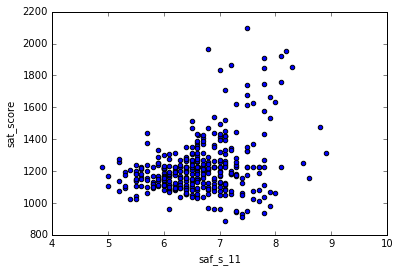

In [11]:
combined.plot.scatter(x="saf_s_11", y="sat_score")

There seems to be some positive relationship between student ratings of safety scores and SAT scores, but it might be driven by only a handful of schools. The most dense cloud of data points actually seems to be entirely flat.

To look at this a little further let's investigate average safety score by district and plot a map to see how safety scores might differ across various boroughs.

In [12]:
avg_safety = combined.groupby("school_dist").agg(numpy.mean).reset_index()

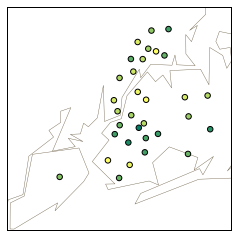

In [13]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#85A6D9', linewidth=.4)
m.scatter(avg_safety['lon'].tolist(),
          avg_safety['lat'].tolist(),
          s=30, zorder=2, latlon=True,
          c=avg_safety['saf_s_11'], cmap="summer")
plt.show()

Above, higher safety ratings are shown in yellow while lower safety ratings are shown in green. Overall it looks like there are higher safety ratings in Manhatten, and much lower safety ratings from students in Brooklyn. We can then make the same map for teacher ratings and see how those compare.

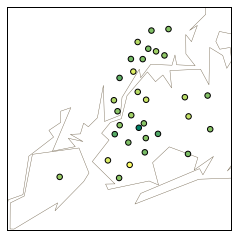

In [14]:
t = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )
t.drawcoastlines(color='#6D5F47', linewidth=.4)
t.drawrivers(color='#85A6D9', linewidth=.4)
t.scatter(avg_safety['lon'].tolist(),
          avg_safety['lat'].tolist(),
          s=30, zorder=2, latlon=True,
          c=avg_safety['saf_t_11'], cmap="summer")
plt.show()

It looks like the two maps roughly match up.

Next we'll look at the percentage of each race at a given school and see how that correlates with SAT scores.

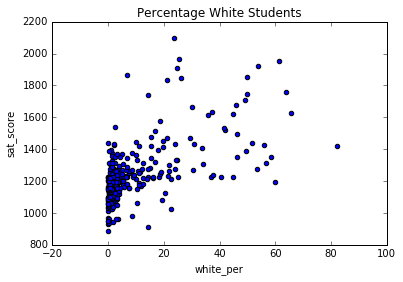

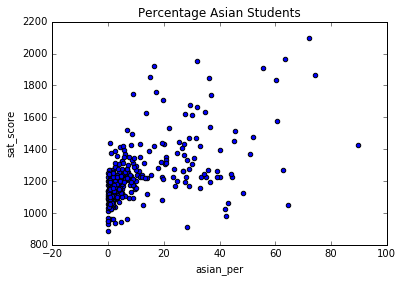

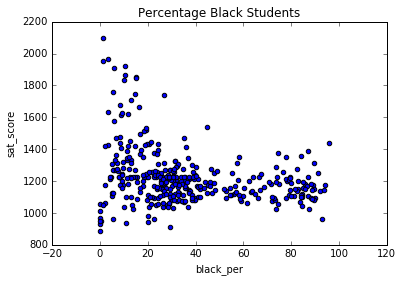

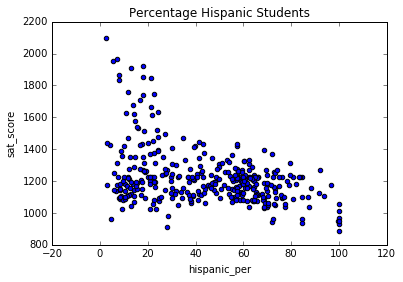

In [15]:
x_vals = ["white_per", "asian_per", "black_per", "hispanic_per"]
x_labs = ["Percentage White Students", "Percentage Asian Students",
          "Percentage Black Students", "Percentage Hispanic Students"]
i=0
for x_val in x_vals:
    combined.plot.scatter(x=x_val, y="sat_score",
                         title=x_labs[i])
    i += 1

Roughly, schools with higher percentages of white and asian students overall seem to have higher SAT scores, while schools with higher percentages of black and hispanic students seem to have lower SAT scores.

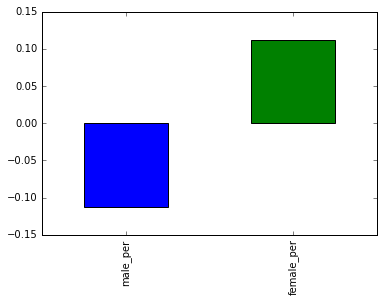

In [16]:
x_vals = ["male_per", "female_per"]
x_labs = ["Percentage Male Students", "Percentage Female Students"]
correlations[x_vals].plot.bar(x=x_val, y="sat_score")

There is a weak relationship between gender and SAT scores. Overall, schools with a higher percentage of female students do better on the SAT while schools with a higher percentage of male students do worse on the SAT. This would suggest that female students have better scores. 

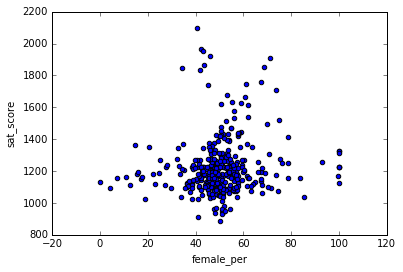

In [17]:
combined.plot.scatter(x="female_per", y="sat_score")

Looking at individual data points we can notice a few interesting things. One is that there is a cluster of schools in the 40-60% range which is to be expected-- most schools will roughly have an equal mix of men and women. Secondly, the postive relationship between percentage of female students and SAT scores seems to be driven by just a few schools that are ~80% female. Let's look into schools that are predominantly (> 60%) female.

In [24]:
high_female = combined[(combined["female_per"] > 60)]
high_female = high_female[(high_female["sat_score"] > 1700)]
print(high_female["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Although all of these schools are public schools, they all have an admissions/screening process. Therefore many of these students have already been selected for high academic acheivement before entering the school.

Next let's look at the relationship between AP exams and SAT scores. Students who choose to take AP classes are also more likely to be high achievers and score well on the SAT exam.

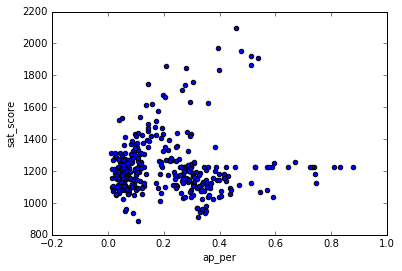

In [26]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x="ap_per", y="sat_score")

While there seems to be a relationship between percentage of students who take at least one AP exam and the average SAT score, there is a surprisingly cluster of data points with 40-90% of students taking an AP exam and a mediocre SAT score.